## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.8 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('NTR.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...,...
1114,2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
1115,2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
1116,2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400
1117,2023-06-09,58.959999,59.349998,58.290001,58.790001,58.790001,1686600


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 6:2:2
train_size = int(len(data_scaled) * 0.6)
val_size = int(len(data_scaled) * 0.2)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [12]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [13]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  train_windows, train_targets = create_dataset(train_data, window_size)
  test_windows, test_targets = create_dataset(test_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [14]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-14 15:53:59,844] A new study created in memory with name: no-name-aa8a9a85-b321-490f-9207-8d616a625523


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 15:54:22,358] Trial 0 finished with value: 5.6438739379822085 and parameters: {'window_size': 91, 'tcn_filters': 61, 'tcn_kernel_size': 4, 'dropout_rate': 0.308885715826885, 'attention_dim': 27}. Best is trial 0 with value: 5.6438739379822085.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 15:54:31,467] Trial 1 finished with value: 8.281082279421616 and parameters: {'window_size': 35, 'tcn_filters': 78, 'tcn_kernel_size': 4, 'dropout_rate': 0.3899753591863636, 'attention_dim': 12}. Best is trial 0 with value: 5.6438739379822085.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 15:54:43,608] Trial 2 finished with value: 5.093034894530716 and parameters: {'window_size': 66, 'tcn_filters': 89, 'tcn_kernel_size': 2, 'dropout_rate': 0.3681326863522667, 'attention_dim': 14}. Best is trial 2 with value: 5.093034894530716.


4/4 [==============================] - 0s 10ms/step


[I 2023-06-14 15:55:05,979] Trial 3 finished with value: 2.7880504532205075 and parameters: {'window_size': 100, 'tcn_filters': 88, 'tcn_kernel_size': 2, 'dropout_rate': 0.1492542465648748, 'attention_dim': 27}. Best is trial 3 with value: 2.7880504532205075.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 15:55:17,792] Trial 4 finished with value: 5.979210978613521 and parameters: {'window_size': 66, 'tcn_filters': 48, 'tcn_kernel_size': 5, 'dropout_rate': 0.2708992234237034, 'attention_dim': 32}. Best is trial 3 with value: 2.7880504532205075.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 15:55:35,283] Trial 5 finished with value: 4.656201822762931 and parameters: {'window_size': 92, 'tcn_filters': 66, 'tcn_kernel_size': 5, 'dropout_rate': 0.26954964985862084, 'attention_dim': 15}. Best is trial 3 with value: 2.7880504532205075.


6/6 [==============================] - 0s 10ms/step


[I 2023-06-14 15:55:54,583] Trial 6 finished with value: 13.502296517823533 and parameters: {'window_size': 37, 'tcn_filters': 125, 'tcn_kernel_size': 3, 'dropout_rate': 0.23907028411492887, 'attention_dim': 23}. Best is trial 3 with value: 2.7880504532205075.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 15:56:17,110] Trial 7 finished with value: 4.840304382176119 and parameters: {'window_size': 83, 'tcn_filters': 112, 'tcn_kernel_size': 3, 'dropout_rate': 0.4786248456362623, 'attention_dim': 10}. Best is trial 3 with value: 2.7880504532205075.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 15:56:39,484] Trial 8 finished with value: 2.474526992304278 and parameters: {'window_size': 80, 'tcn_filters': 117, 'tcn_kernel_size': 2, 'dropout_rate': 0.2983986299377154, 'attention_dim': 16}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 15:57:01,948] Trial 9 finished with value: 2.9397198658745607 and parameters: {'window_size': 96, 'tcn_filters': 46, 'tcn_kernel_size': 2, 'dropout_rate': 0.3094215197721975, 'attention_dim': 32}. Best is trial 8 with value: 2.474526992304278.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:57:10,255] Trial 10 finished with value: 11.823202893096232 and parameters: {'window_size': 16, 'tcn_filters': 106, 'tcn_kernel_size': 3, 'dropout_rate': 0.14343335971336021, 'attention_dim': 18}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 15:57:32,767] Trial 11 finished with value: 6.003722664688757 and parameters: {'window_size': 75, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.11746163365361129, 'attention_dim': 23}. Best is trial 8 with value: 2.474526992304278.


4/4 [==============================] - 0s 11ms/step


[I 2023-06-14 15:57:54,582] Trial 12 finished with value: 4.637946946127806 and parameters: {'window_size': 100, 'tcn_filters': 122, 'tcn_kernel_size': 2, 'dropout_rate': 0.18868216425248419, 'attention_dim': 19}. Best is trial 8 with value: 2.474526992304278.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:58:17,657] Trial 13 finished with value: 4.056088552723214 and parameters: {'window_size': 52, 'tcn_filters': 91, 'tcn_kernel_size': 2, 'dropout_rate': 0.1889882730439767, 'attention_dim': 26}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 15:58:34,920] Trial 14 finished with value: 4.556839672735061 and parameters: {'window_size': 78, 'tcn_filters': 77, 'tcn_kernel_size': 3, 'dropout_rate': 0.10751212182494986, 'attention_dim': 8}. Best is trial 8 with value: 2.474526992304278.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:58:43,864] Trial 15 finished with value: 6.510328040471431 and parameters: {'window_size': 57, 'tcn_filters': 34, 'tcn_kernel_size': 2, 'dropout_rate': 0.20048627836660646, 'attention_dim': 28}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 15:59:03,511] Trial 16 finished with value: 14.877309987598583 and parameters: {'window_size': 84, 'tcn_filters': 96, 'tcn_kernel_size': 4, 'dropout_rate': 0.15454943727967027, 'attention_dim': 22}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 15:59:26,077] Trial 17 finished with value: 13.186857803058885 and parameters: {'window_size': 70, 'tcn_filters': 111, 'tcn_kernel_size': 3, 'dropout_rate': 0.2116118025887997, 'attention_dim': 16}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 15:59:52,787] Trial 18 finished with value: 4.268970896991755 and parameters: {'window_size': 88, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.24049804445647066, 'attention_dim': 29}. Best is trial 8 with value: 2.474526992304278.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 16:00:04,950] Trial 19 finished with value: 19.058796727306415 and parameters: {'window_size': 55, 'tcn_filters': 83, 'tcn_kernel_size': 3, 'dropout_rate': 0.10020103119310558, 'attention_dim': 21}. Best is trial 8 with value: 2.474526992304278.


4/4 [==============================] - 0s 12ms/step


[I 2023-06-14 16:00:29,949] Trial 20 finished with value: 3.831688362546977 and parameters: {'window_size': 100, 'tcn_filters': 116, 'tcn_kernel_size': 2, 'dropout_rate': 0.152470774144144, 'attention_dim': 17}. Best is trial 8 with value: 2.474526992304278.


4/4 [==============================] - 0s 6ms/step


[I 2023-06-14 16:00:43,876] Trial 21 finished with value: 9.985313730725295 and parameters: {'window_size': 98, 'tcn_filters': 32, 'tcn_kernel_size': 2, 'dropout_rate': 0.336842966107394, 'attention_dim': 32}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 16:01:06,357] Trial 22 finished with value: 5.3207849359341965 and parameters: {'window_size': 92, 'tcn_filters': 55, 'tcn_kernel_size': 2, 'dropout_rate': 0.3051541648124829, 'attention_dim': 30}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 16:01:29,065] Trial 23 finished with value: 4.491336215514636 and parameters: {'window_size': 80, 'tcn_filters': 68, 'tcn_kernel_size': 2, 'dropout_rate': 0.2699455879420346, 'attention_dim': 25}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 16:01:40,148] Trial 24 finished with value: 13.53596224754523 and parameters: {'window_size': 92, 'tcn_filters': 47, 'tcn_kernel_size': 3, 'dropout_rate': 0.34422908649671513, 'attention_dim': 30}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 16:01:52,356] Trial 25 finished with value: 10.447428900096853 and parameters: {'window_size': 73, 'tcn_filters': 42, 'tcn_kernel_size': 2, 'dropout_rate': 0.40353119519819947, 'attention_dim': 32}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 16:02:07,765] Trial 26 finished with value: 42.992102763635366 and parameters: {'window_size': 84, 'tcn_filters': 71, 'tcn_kernel_size': 3, 'dropout_rate': 0.23848422506979522, 'attention_dim': 25}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 16:02:23,171] Trial 27 finished with value: 5.351440716157911 and parameters: {'window_size': 96, 'tcn_filters': 102, 'tcn_kernel_size': 2, 'dropout_rate': 0.2930171057842113, 'attention_dim': 20}. Best is trial 8 with value: 2.474526992304278.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 16:02:27,612] Trial 28 finished with value: 37.74947692244854 and parameters: {'window_size': 46, 'tcn_filters': 58, 'tcn_kernel_size': 4, 'dropout_rate': 0.33814385135786373, 'attention_dim': 14}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 16:02:43,175] Trial 29 finished with value: 3.0126474870472717 and parameters: {'window_size': 88, 'tcn_filters': 91, 'tcn_kernel_size': 2, 'dropout_rate': 0.3176349724897993, 'attention_dim': 27}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 16:03:01,731] Trial 30 finished with value: 18.20698052926773 and parameters: {'window_size': 94, 'tcn_filters': 120, 'tcn_kernel_size': 4, 'dropout_rate': 0.17333279087129053, 'attention_dim': 30}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 16:03:14,899] Trial 31 finished with value: 3.0152638912613092 and parameters: {'window_size': 87, 'tcn_filters': 87, 'tcn_kernel_size': 2, 'dropout_rate': 0.3184149758680083, 'attention_dim': 28}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 16:03:37,458] Trial 32 finished with value: 5.929824994766565 and parameters: {'window_size': 88, 'tcn_filters': 74, 'tcn_kernel_size': 2, 'dropout_rate': 0.29341267817607136, 'attention_dim': 27}. Best is trial 8 with value: 2.474526992304278.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 16:03:44,701] Trial 33 finished with value: 7.274667941413965 and parameters: {'window_size': 16, 'tcn_filters': 94, 'tcn_kernel_size': 2, 'dropout_rate': 0.368543039440115, 'attention_dim': 12}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 16:04:03,235] Trial 34 finished with value: 5.51170902581392 and parameters: {'window_size': 65, 'tcn_filters': 81, 'tcn_kernel_size': 2, 'dropout_rate': 0.22100587548465703, 'attention_dim': 25}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 16:04:20,177] Trial 35 finished with value: 12.163435824986422 and parameters: {'window_size': 79, 'tcn_filters': 86, 'tcn_kernel_size': 5, 'dropout_rate': 0.2625117955220184, 'attention_dim': 31}. Best is trial 8 with value: 2.474526992304278.


6/6 [==============================] - 1s 8ms/step


[I 2023-06-14 16:04:43,540] Trial 36 finished with value: 8.783087039851498 and parameters: {'window_size': 62, 'tcn_filters': 63, 'tcn_kernel_size': 3, 'dropout_rate': 0.28940367211212564, 'attention_dim': 23}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 16:05:06,704] Trial 37 finished with value: 3.2342300926866283 and parameters: {'window_size': 95, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.3198074248519585, 'attention_dim': 27}. Best is trial 8 with value: 2.474526992304278.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 16:05:24,060] Trial 38 finished with value: 6.2656021361128795 and parameters: {'window_size': 31, 'tcn_filters': 106, 'tcn_kernel_size': 3, 'dropout_rate': 0.2559703834005106, 'attention_dim': 12}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 16:05:46,803] Trial 39 finished with value: 3.5718642785799455 and parameters: {'window_size': 72, 'tcn_filters': 78, 'tcn_kernel_size': 2, 'dropout_rate': 0.2830300973489579, 'attention_dim': 24}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 16:06:02,356] Trial 40 finished with value: 5.005433206662041 and parameters: {'window_size': 89, 'tcn_filters': 111, 'tcn_kernel_size': 5, 'dropout_rate': 0.4083683280880944, 'attention_dim': 14}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 16:06:15,219] Trial 41 finished with value: 5.481807232135722 and parameters: {'window_size': 86, 'tcn_filters': 91, 'tcn_kernel_size': 2, 'dropout_rate': 0.31719420799777287, 'attention_dim': 27}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 16:06:31,070] Trial 42 finished with value: 4.467844516359031 and parameters: {'window_size': 82, 'tcn_filters': 85, 'tcn_kernel_size': 2, 'dropout_rate': 0.3115986492295449, 'attention_dim': 29}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 16:06:45,463] Trial 43 finished with value: 6.427738479104775 and parameters: {'window_size': 91, 'tcn_filters': 96, 'tcn_kernel_size': 2, 'dropout_rate': 0.36084347953950136, 'attention_dim': 28}. Best is trial 8 with value: 2.474526992304278.


4/4 [==============================] - 0s 8ms/step


[I 2023-06-14 16:06:57,584] Trial 44 finished with value: 3.2290741392242253 and parameters: {'window_size': 100, 'tcn_filters': 89, 'tcn_kernel_size': 2, 'dropout_rate': 0.27842659017700877, 'attention_dim': 19}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 16:07:20,977] Trial 45 finished with value: 6.989513532548356 and parameters: {'window_size': 75, 'tcn_filters': 74, 'tcn_kernel_size': 2, 'dropout_rate': 0.1209856495705132, 'attention_dim': 29}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 16:07:43,221] Trial 46 finished with value: 3.7767082896821806 and parameters: {'window_size': 96, 'tcn_filters': 106, 'tcn_kernel_size': 3, 'dropout_rate': 0.254541961541827, 'attention_dim': 26}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 16:08:05,734] Trial 47 finished with value: 3.7927762835660164 and parameters: {'window_size': 77, 'tcn_filters': 54, 'tcn_kernel_size': 2, 'dropout_rate': 0.22443992415093333, 'attention_dim': 31}. Best is trial 8 with value: 2.474526992304278.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 16:08:18,628] Trial 48 finished with value: 4.69382574674918 and parameters: {'window_size': 11, 'tcn_filters': 87, 'tcn_kernel_size': 2, 'dropout_rate': 0.3042568890268168, 'attention_dim': 22}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 16:08:28,671] Trial 49 finished with value: 8.362654777176182 and parameters: {'window_size': 86, 'tcn_filters': 39, 'tcn_kernel_size': 3, 'dropout_rate': 0.18429442224840675, 'attention_dim': 16}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 16:08:51,036] Trial 50 finished with value: 5.043009471374449 and parameters: {'window_size': 82, 'tcn_filters': 94, 'tcn_kernel_size': 2, 'dropout_rate': 0.3288487068262133, 'attention_dim': 31}. Best is trial 8 with value: 2.474526992304278.


4/4 [==============================] - 0s 12ms/step


[I 2023-06-14 16:09:01,378] Trial 51 finished with value: 5.442893791390036 and parameters: {'window_size': 100, 'tcn_filters': 82, 'tcn_kernel_size': 2, 'dropout_rate': 0.27475425215524574, 'attention_dim': 19}. Best is trial 8 with value: 2.474526992304278.


4/4 [==============================] - 0s 12ms/step


[I 2023-06-14 16:09:15,277] Trial 52 finished with value: 6.3452594685171375 and parameters: {'window_size': 97, 'tcn_filters': 89, 'tcn_kernel_size': 2, 'dropout_rate': 0.28451101699189896, 'attention_dim': 18}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 16:09:35,952] Trial 53 finished with value: 2.534944841025275 and parameters: {'window_size': 91, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.3028452939935367, 'attention_dim': 20}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 13ms/step


[I 2023-06-14 16:09:58,557] Trial 54 finished with value: 3.204597981139815 and parameters: {'window_size': 90, 'tcn_filters': 116, 'tcn_kernel_size': 2, 'dropout_rate': 0.30162232560910274, 'attention_dim': 21}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 16:10:16,758] Trial 55 finished with value: 3.19457781204285 and parameters: {'window_size': 93, 'tcn_filters': 103, 'tcn_kernel_size': 2, 'dropout_rate': 0.3214808216679211, 'attention_dim': 28}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 16:10:39,185] Trial 56 finished with value: 4.695784574767897 and parameters: {'window_size': 86, 'tcn_filters': 98, 'tcn_kernel_size': 2, 'dropout_rate': 0.3463812693546013, 'attention_dim': 24}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 17ms/step


[I 2023-06-14 16:10:59,278] Trial 57 finished with value: 3.6043106013325628 and parameters: {'window_size': 89, 'tcn_filters': 124, 'tcn_kernel_size': 3, 'dropout_rate': 0.24507824840495768, 'attention_dim': 17}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 16:11:21,877] Trial 58 finished with value: 4.155542519538969 and parameters: {'window_size': 94, 'tcn_filters': 106, 'tcn_kernel_size': 2, 'dropout_rate': 0.3063991495610786, 'attention_dim': 10}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 16:11:31,526] Trial 59 finished with value: 7.952163844568149 and parameters: {'window_size': 68, 'tcn_filters': 92, 'tcn_kernel_size': 2, 'dropout_rate': 0.26597629735387396, 'attention_dim': 26}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 19ms/step


[I 2023-06-14 16:11:54,121] Trial 60 finished with value: 10.299272409500398 and parameters: {'window_size': 80, 'tcn_filters': 114, 'tcn_kernel_size': 2, 'dropout_rate': 0.3279261582610812, 'attention_dim': 21}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 1s 8ms/step


[I 2023-06-14 16:12:38,764] Trial 61 finished with value: 3.7864951941411817 and parameters: {'window_size': 91, 'tcn_filters': 102, 'tcn_kernel_size': 2, 'dropout_rate': 0.31974115945468573, 'attention_dim': 28}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 16:12:58,964] Trial 62 finished with value: 3.0970005694750418 and parameters: {'window_size': 93, 'tcn_filters': 103, 'tcn_kernel_size': 2, 'dropout_rate': 0.29981842096905814, 'attention_dim': 29}. Best is trial 8 with value: 2.474526992304278.


4/4 [==============================] - 0s 14ms/step


[I 2023-06-14 16:13:18,345] Trial 63 finished with value: 3.3176255061698727 and parameters: {'window_size': 97, 'tcn_filters': 110, 'tcn_kernel_size': 2, 'dropout_rate': 0.2892330671163498, 'attention_dim': 30}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 16:13:43,560] Trial 64 finished with value: 3.117723159690455 and parameters: {'window_size': 85, 'tcn_filters': 120, 'tcn_kernel_size': 2, 'dropout_rate': 0.3002684781445786, 'attention_dim': 32}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 16:13:56,030] Trial 65 finished with value: 4.73317719445128 and parameters: {'window_size': 94, 'tcn_filters': 97, 'tcn_kernel_size': 2, 'dropout_rate': 0.2724416888688086, 'attention_dim': 26}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 16:14:16,698] Trial 66 finished with value: 3.6886480189725828 and parameters: {'window_size': 82, 'tcn_filters': 85, 'tcn_kernel_size': 2, 'dropout_rate': 0.35014872464758234, 'attention_dim': 29}. Best is trial 8 with value: 2.474526992304278.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 16:14:29,563] Trial 67 finished with value: 7.580105857291735 and parameters: {'window_size': 32, 'tcn_filters': 80, 'tcn_kernel_size': 3, 'dropout_rate': 0.33146665012347565, 'attention_dim': 31}. Best is trial 8 with value: 2.474526992304278.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 16:14:52,240] Trial 68 finished with value: 9.29725461230779 and parameters: {'window_size': 43, 'tcn_filters': 93, 'tcn_kernel_size': 2, 'dropout_rate': 0.20341044071491163, 'attention_dim': 15}. Best is trial 8 with value: 2.474526992304278.


4/4 [==============================] - 0s 21ms/step


[I 2023-06-14 16:15:14,747] Trial 69 finished with value: 2.9013683949320916 and parameters: {'window_size': 98, 'tcn_filters': 109, 'tcn_kernel_size': 2, 'dropout_rate': 0.3727477998079328, 'attention_dim': 24}. Best is trial 8 with value: 2.474526992304278.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 16:15:38,976] Trial 70 finished with value: 6.450546674293483 and parameters: {'window_size': 88, 'tcn_filters': 110, 'tcn_kernel_size': 3, 'dropout_rate': 0.379035629806892, 'attention_dim': 24}. Best is trial 8 with value: 2.474526992304278.


4/4 [==============================] - 0s 11ms/step


[I 2023-06-14 16:16:01,525] Trial 71 finished with value: 2.4207071608716113 and parameters: {'window_size': 98, 'tcn_filters': 108, 'tcn_kernel_size': 2, 'dropout_rate': 0.3098515960677264, 'attention_dim': 27}. Best is trial 71 with value: 2.4207071608716113.


4/4 [==============================] - 0s 9ms/step


[I 2023-06-14 16:16:29,954] Trial 72 finished with value: 12.223197532988435 and parameters: {'window_size': 100, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.33716041067630115, 'attention_dim': 25}. Best is trial 71 with value: 2.4207071608716113.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 16:16:52,343] Trial 73 finished with value: 2.804615790261486 and parameters: {'window_size': 96, 'tcn_filters': 108, 'tcn_kernel_size': 2, 'dropout_rate': 0.31036112355912265, 'attention_dim': 23}. Best is trial 71 with value: 2.4207071608716113.


4/4 [==============================] - 0s 10ms/step


[I 2023-06-14 16:17:08,123] Trial 74 finished with value: 9.307373780367252 and parameters: {'window_size': 98, 'tcn_filters': 118, 'tcn_kernel_size': 2, 'dropout_rate': 0.3557503673789657, 'attention_dim': 22}. Best is trial 71 with value: 2.4207071608716113.


4/4 [==============================] - 0s 12ms/step


[I 2023-06-14 16:17:31,062] Trial 75 finished with value: 6.355799632329812 and parameters: {'window_size': 97, 'tcn_filters': 106, 'tcn_kernel_size': 2, 'dropout_rate': 0.34246170227294154, 'attention_dim': 24}. Best is trial 71 with value: 2.4207071608716113.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 16:18:13,960] Trial 76 finished with value: 2.369749244136042 and parameters: {'window_size': 91, 'tcn_filters': 109, 'tcn_kernel_size': 2, 'dropout_rate': 0.36213528365287284, 'attention_dim': 20}. Best is trial 76 with value: 2.369749244136042.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 16:18:30,949] Trial 77 finished with value: 5.630426923151059 and parameters: {'window_size': 91, 'tcn_filters': 114, 'tcn_kernel_size': 2, 'dropout_rate': 0.37366053353719153, 'attention_dim': 20}. Best is trial 76 with value: 2.369749244136042.


4/4 [==============================] - 0s 14ms/step


[I 2023-06-14 16:18:54,809] Trial 78 finished with value: 10.952806091961792 and parameters: {'window_size': 98, 'tcn_filters': 109, 'tcn_kernel_size': 4, 'dropout_rate': 0.39052767111472253, 'attention_dim': 23}. Best is trial 76 with value: 2.369749244136042.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 16:19:37,906] Trial 79 finished with value: 4.081463276666245 and parameters: {'window_size': 96, 'tcn_filters': 113, 'tcn_kernel_size': 2, 'dropout_rate': 0.35779882766470517, 'attention_dim': 22}. Best is trial 76 with value: 2.369749244136042.


4/4 [==============================] - 0s 13ms/step


[I 2023-06-14 16:20:00,487] Trial 80 finished with value: 2.8696222378376284 and parameters: {'window_size': 100, 'tcn_filters': 108, 'tcn_kernel_size': 2, 'dropout_rate': 0.2812739659731278, 'attention_dim': 18}. Best is trial 76 with value: 2.369749244136042.


4/4 [==============================] - 0s 9ms/step


[I 2023-06-14 16:20:17,403] Trial 81 finished with value: 3.2683062628188835 and parameters: {'window_size': 100, 'tcn_filters': 108, 'tcn_kernel_size': 2, 'dropout_rate': 0.31123513938124875, 'attention_dim': 20}. Best is trial 76 with value: 2.369749244136042.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 16:20:39,594] Trial 82 finished with value: 2.4145448017720557 and parameters: {'window_size': 95, 'tcn_filters': 127, 'tcn_kernel_size': 2, 'dropout_rate': 0.28195842991555015, 'attention_dim': 17}. Best is trial 76 with value: 2.369749244136042.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 16:21:06,463] Trial 83 finished with value: 2.5308796733930383 and parameters: {'window_size': 94, 'tcn_filters': 123, 'tcn_kernel_size': 2, 'dropout_rate': 0.28049446630805525, 'attention_dim': 18}. Best is trial 76 with value: 2.369749244136042.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 16:21:23,365] Trial 84 finished with value: 8.822093674395145 and parameters: {'window_size': 94, 'tcn_filters': 127, 'tcn_kernel_size': 2, 'dropout_rate': 0.28810613846376504, 'attention_dim': 18}. Best is trial 76 with value: 2.369749244136042.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 16:22:06,867] Trial 85 finished with value: 2.5904958529911033 and parameters: {'window_size': 92, 'tcn_filters': 123, 'tcn_kernel_size': 2, 'dropout_rate': 0.2796516970695871, 'attention_dim': 17}. Best is trial 76 with value: 2.369749244136042.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 16:22:50,602] Trial 86 finished with value: 3.913535854705279 and parameters: {'window_size': 92, 'tcn_filters': 122, 'tcn_kernel_size': 2, 'dropout_rate': 0.2601015445728585, 'attention_dim': 17}. Best is trial 76 with value: 2.369749244136042.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 16:23:11,026] Trial 87 finished with value: 2.2527763501303544 and parameters: {'window_size': 90, 'tcn_filters': 125, 'tcn_kernel_size': 2, 'dropout_rate': 0.24858197900972026, 'attention_dim': 16}. Best is trial 87 with value: 2.2527763501303544.


5/5 [==============================] - 0s 17ms/step


[I 2023-06-14 16:23:32,809] Trial 88 finished with value: 4.084570888439204 and parameters: {'window_size': 90, 'tcn_filters': 125, 'tcn_kernel_size': 2, 'dropout_rate': 0.24930599405298634, 'attention_dim': 15}. Best is trial 87 with value: 2.2527763501303544.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 16:23:53,925] Trial 89 finished with value: 2.6720704484790243 and parameters: {'window_size': 84, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.2720110503233503, 'attention_dim': 16}. Best is trial 87 with value: 2.2527763501303544.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 16:24:36,827] Trial 90 finished with value: 2.715809394426477 and parameters: {'window_size': 76, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.27358222635674717, 'attention_dim': 16}. Best is trial 87 with value: 2.2527763501303544.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 16:25:19,724] Trial 91 finished with value: 3.980253793148153 and parameters: {'window_size': 83, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.2677472526817347, 'attention_dim': 16}. Best is trial 87 with value: 2.2527763501303544.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 16:25:41,603] Trial 92 finished with value: 2.7017062379993084 and parameters: {'window_size': 76, 'tcn_filters': 122, 'tcn_kernel_size': 2, 'dropout_rate': 0.2723639595978041, 'attention_dim': 14}. Best is trial 87 with value: 2.2527763501303544.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 16:26:04,187] Trial 93 finished with value: 3.7218713129097254 and parameters: {'window_size': 73, 'tcn_filters': 122, 'tcn_kernel_size': 2, 'dropout_rate': 0.29497783090096463, 'attention_dim': 13}. Best is trial 87 with value: 2.2527763501303544.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 16:26:26,623] Trial 94 finished with value: 2.5297290166410673 and parameters: {'window_size': 84, 'tcn_filters': 119, 'tcn_kernel_size': 2, 'dropout_rate': 0.26180882012751194, 'attention_dim': 17}. Best is trial 87 with value: 2.2527763501303544.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 16:26:48,681] Trial 95 finished with value: 7.448404270294911 and parameters: {'window_size': 84, 'tcn_filters': 119, 'tcn_kernel_size': 2, 'dropout_rate': 0.2366310757269268, 'attention_dim': 17}. Best is trial 87 with value: 2.2527763501303544.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 16:27:09,942] Trial 96 finished with value: 2.454064060389551 and parameters: {'window_size': 79, 'tcn_filters': 116, 'tcn_kernel_size': 2, 'dropout_rate': 0.25892983572834155, 'attention_dim': 18}. Best is trial 87 with value: 2.2527763501303544.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 16:27:32,227] Trial 97 finished with value: 16.60657138837232 and parameters: {'window_size': 79, 'tcn_filters': 117, 'tcn_kernel_size': 5, 'dropout_rate': 0.2577201090080592, 'attention_dim': 19}. Best is trial 87 with value: 2.2527763501303544.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 16:27:51,359] Trial 98 finished with value: 4.112731091556176 and parameters: {'window_size': 87, 'tcn_filters': 116, 'tcn_kernel_size': 2, 'dropout_rate': 0.2843471958977558, 'attention_dim': 19}. Best is trial 87 with value: 2.2527763501303544.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 16:28:14,124] Trial 99 finished with value: 6.065318626438988 and parameters: {'window_size': 89, 'tcn_filters': 125, 'tcn_kernel_size': 2, 'dropout_rate': 0.25367182371921104, 'attention_dim': 18}. Best is trial 87 with value: 2.2527763501303544.


In [15]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 90, 'tcn_filters': 125, 'tcn_kernel_size': 2, 'dropout_rate': 0.24858197900972026, 'attention_dim': 16}


In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.0167444353502629
RMSE on Test dataset:  1.5009251647335233
MSLE on Test dataset:  0.00042891462794826795


### Save and Load the best model and related information

In [17]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_msle.npy', best_msle)

In [18]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [19]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [20]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 22ms/step


In [21]:
print('Predicted closing prices for the next 30 days:')
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[59.21758  58.815746 58.393726 57.950596 57.481762 56.983356 56.45382
 55.892345 55.29699  54.664074 53.990307 53.272667 52.515545 51.71672
 50.873886 49.983788 49.046547 48.066303 47.087425 46.13161  45.207684
 44.33819  43.55154  42.800556 42.0599   41.369297 40.732162 40.06992
 39.470825 38.937748]


## Visualization

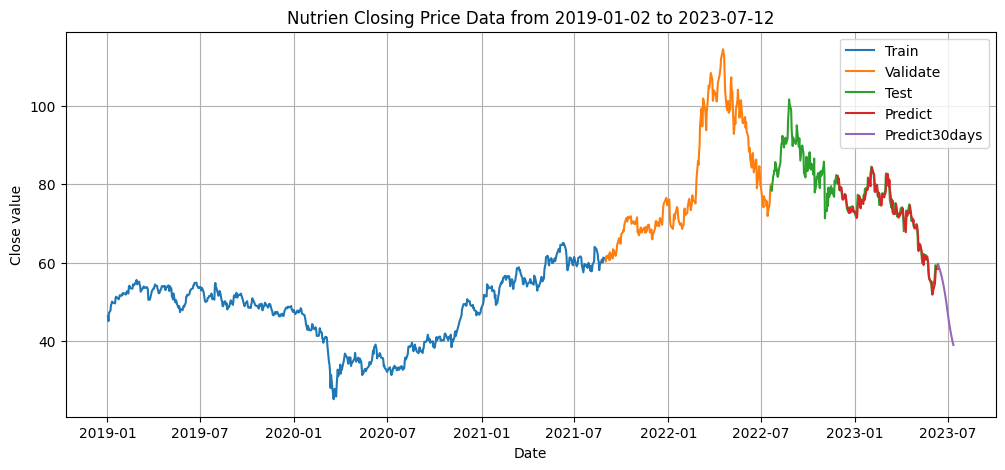

In [22]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + best_window_size: ], best_y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Nutrien Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_622_NTR.png')
plt.show()